In [117]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import gc
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import warnings
warnings.filterwarnings('ignore')

1. 离群点检测: 训练数据包含离群点,即远离其它内围点。离群点检测估计器会尝试拟合出训练数据中内围点聚集的区域, 会忽略有偏离的观测值。
2. 新奇点检测: 训练数据未被离群点污染，我们对新观测值是否为离群点感兴趣。在这个语境下，离群点被认为是新奇点。

In [2]:
data = pd.read_csv('./creditcard.csv')

In [15]:
y = data.pop('Class')

In [22]:
y = y.values

In [17]:
data = data.drop(columns='Time')

In [14]:
# 归一化
mms = MinMaxScaler()
X = mms.fit_transform(data)

In [36]:
print('样本数:%s,特征数:%s'%(len(X),X.shape[1]))

样本数:284807,特征数:29


In [46]:
# 训练集、测试集划分
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,shuffle=True,stratify=y)

In [49]:
del data,X,y
gc.collect()

190

## IsolationForest

- 孤立森林（也叫隔离森林）

- 高维数据集适合使用此方法
- 孤立森林通过随机选择一个特征,随机选择所选特征的最大值和最小值之间的分割值来"隔离"观测。  
- 由于递归划分可以由树形结构表示，因此隔离样本所需的分割次数等同于从根节点到终止节点的路径长度。  
- 在这样的随机树的森林中取平均的路径长度是数据正态性和我们的决策功能的量度。  
- 随机划分能为异常观测产生明显的较短路径。因此，当随机树的森林共同地为特定样本产生较短的路径长度时，这些样本就很有可能是异常的。

### 使用creditcard数据集

In [55]:
Ilf_params = {
    'n_estimators':200, 
    'max_samples':500, # 每个估计器用到的样本数。Int、float、"auto"(默认,min(256,n_samples))
    'contamination':0.002,  # 异常值或离群点的占比。用于定义决策函数的阈值。
    'max_features':0.8,  # 每个估计期用到的特征数。int或者float
    'bootstrap':True, # False(default)：不放回抽样，True：单个树在随机子集上训练，且有放回。
    'n_jobs':3, 
    'behaviour':'new', 
    'random_state':42, 
    'verbose':0, 
    'warm_start':True
}

In [59]:
Ilf = IsolationForest(**Ilf_params)

In [60]:
# 训练
Ilf.fit(X=X_train)

IsolationForest(behaviour='new', bootstrap=True, contamination=0.002,
                max_features=0.8, max_samples=500, n_estimators=200, n_jobs=3,
                random_state=42, verbose=0, warm_start=True)

In [62]:
# 预测
train_pred = Ilf.predict(X_train)
test_pred = Ilf.predict(X_test)

In [85]:
# 查看预测结果，1代表正常值，-1代表离群值
# 训练集
_=np.concatenate([y_train.reshape(-1,1),train_pred.reshape(-1,1)],axis=1)
pd.DataFrame(_,columns=['true','pred']).groupby(['true','pred']).size()

true  pred
0     -1         293
       1      198727
1     -1         106
       1         238
dtype: int64

In [92]:
# 测试集
_=np.concatenate([y_test.reshape(-1,1),test_pred.reshape(-1,1)],axis=1)
pd.DataFrame(_,columns=['true','pred']).groupby(['true','pred']).size()

true  pred
0     -1        127
       1      85168
1     -1         39
       1        109
dtype: int64

### 使用自定义数据

In [94]:
rng=np.random.RandomState(42)
# 生成训练数据
X=0.3*rng.randn(100,2) # 100条二维数据
X_train=np.r_[X+2,X-2] # 200条数据（X+2,X-2）拼接而成

X = 0.3 * rng.randn(20, 2)
X_test = np.r_[X + 2, X - 2]
# 基于分布生成一些观测正常的数据
X_outliers=rng.uniform(low=-4,high=4,size=(20,2))

In [95]:
# 训练
rlf=IsolationForest(**Ilf_params)
rlf.fit(X_train)

D:\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:274: UserWarning: max_samples (500) is greater than the total number of samples (200). max_samples will be set to n_samples for estimation.
  % (self.max_samples, n_samples))


IsolationForest(behaviour='new', bootstrap=True, contamination=0.002,
                max_features=0.8, max_samples=500, n_estimators=200, n_jobs=3,
                random_state=42, verbose=0, warm_start=True)

In [96]:
# 预测
y_pred_train=rlf.predict(X_train)
y_pred_test=rlf.predict(X_test)
y_pred_outliers = rlf.predict(X_outliers)

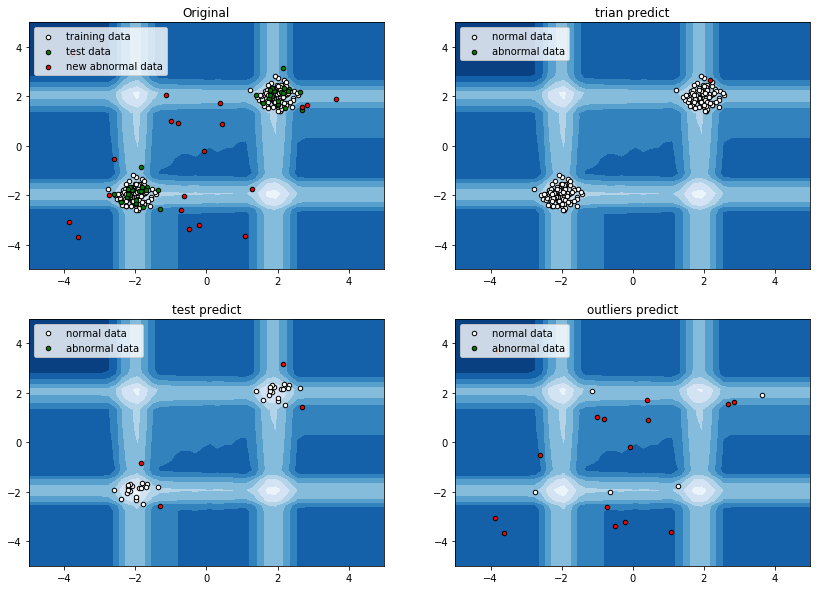

In [116]:
# 画图
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Z = rlf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c='white',
                 s=20, edgecolor='k')
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='green',
                 s=20, edgecolor='k')
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red',
                s=20, edgecolor='k')
plt.title('Original')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.legend([b1, b2, c],["training data","test data", "new abnormal data"],loc="upper left")

n = 2
for x,x_pred,title in zip([X_train,X_test,X_outliers],[y_pred_train,y_pred_test,y_pred_outliers],['trian','test','outliers']):
    plt.subplot(2,2,n)
    xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
    Z = rlf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

    b1 = plt.scatter(x[x_pred==1][:, 0], x[x_pred==1][:, 1], c='white',
                     s=20, edgecolor='k')
    c = plt.scatter(x[x_pred==-1][:, 0], x[x_pred==-1][:, 1], c='red',
                    s=20, edgecolor='k')
    plt.title('%s predict'%title)
    plt.axis('tight')
    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend([b1, b2, c],["normal data","abnormal data"],loc="upper left")
    n+=1

## Local Outlier Factor
- 局部离群因子

- 适合轻度高维数据集
- 计算出反映观测异常程度的得分（称为局部离群因子）
- 它测量给定数据点相对于其邻近点的局部密度偏差。算法思想是检测出具有比其邻近点明显更低密度的样本
- 局部密度从k个最近邻得到。观测数据的LOF得分=其k个最近邻的平均局部密度与其本身密度的比值：正常情况预期与其近邻有着类似的局部密度，而异常数据则预计比近邻的局部密度要小得多。
- LOF算法的优点是考虑到数据集的局部和全局属性：即使在具有不同潜在密度的离群点数据集中，它也能够表现得很好。问题不在于样本是如何被分离的，而是样本与周围近邻的分离程度有多大

In [268]:
lof_param ={'n_neighbors':20,  # 近邻样本数。当离群点的比例较高时（大于10%时），n_neighbors应该较大
            'algorithm':'auto', # ball_tree、kd_tree、brute、out(default,自动选择)
            'leaf_size':30, 
            'metric':'minkowski', 
            'p':2, 
            'metric_params':None, 
            'contamination':0.2, # 异常样本比例
            'novelty':False,  # 是否新奇点检测。默认False
            'n_jobs':3}

In [149]:
rng = np.random.RandomState(42)
X = 0.3 * rng.randn(n_inliers // 2, 2)
X_train = np.r_[X + 2, X - 2]   #正常样本
X_train = np.r_[X_train, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))] # 增加离群样本

In [137]:
n_samples = 200  #样本总数
outliers_fraction = 0.2  #异常样本比例
n_inliers = int((1. - outliers_fraction) * n_samples) # 正常样本数
n_outliers = int(outliers_fraction * n_samples) #异常样本数

- 当novelty参数被设为True时，要当心。在新的未见过的数据上，你只能使用predict, decision_function和score_samples ，而不能把这几个函数用在训练数据上，否则会导致错误的结果。
- 进行离群点检测的时候（novelty为False），不能使用predict, decisionfunction 和 score_samples 方法，只能使用 fit_predict 方法

In [138]:
# 训练模型并确立阈值
clf = LocalOutlierFactor(**lof_param)
y_pred = clf.fit_predict(X_train)
scores_pred = clf.negative_outlier_factor_  # 异常得分，绝对值越大越异常
threshold = stats.scoreatpercentile(scores_pred, 100 * 0.2)  # 根据异常样本比例，得到阈值，用于绘图

D:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [150]:
print('threshold is %s'%threshold)

threshold is -1.748304645236958


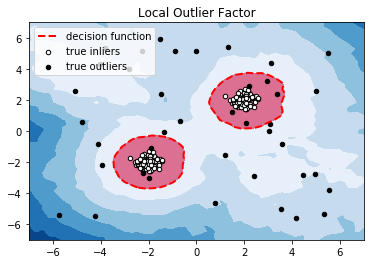

In [143]:
# 绘图
xx, yy = np.meshgrid(np.linspace(-7, 7, 50), np.linspace(-7, 7, 50))
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.title("Local Outlier Factor")

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Blues_r)  # 绘制异常点区域
a = plt.contour(xx, yy, Z, levels=[threshold], linewidths=2, colors='red')  # 绘制边界
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='palevioletred')  # 绘制正常点区域

b = plt.scatter(X_train[:-n_outliers, 0], X_train[:-n_outliers, 1], c='white',
                    s=20, edgecolor='k')
c = plt.scatter(X_train[-n_outliers:, 0], X_train[-n_outliers:, 1], c='black',
                    s=20, edgecolor='k')
plt.axis('tight')
plt.xlim((-7, 7))
plt.ylim((-7, 7))
plt.legend([a.collections[0], b, c],['decision function', 'true inliers', 'true outliers'],loc="upper left")

## 高斯异常检测

适用于简单的离群点检测，要求数据服从高斯分布。在训练集上训练高斯模型，无需异常标签，验证集上调节参数和确定阈值，需要有异常标签。

### 二元

In [175]:
import scipy.io as sio

In [176]:
data=sio.loadmat('./ex8data1.mat')

In [178]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [179]:
# 训练集构建高斯模型，验证集确立阈值
X = data.get('X')
X_val = data.get('Xval')
y_val = data.get('yval').ravel()

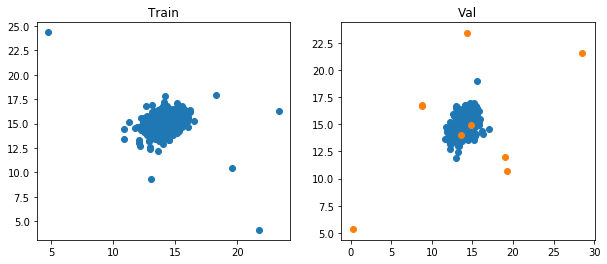

In [194]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Train')
plt.scatter(X[:,0],X[:,1])
plt.subplot(1,2,2)
plt.title('Val')
plt.scatter(X_val[y_val==0][:,0],X_val[y_val==0][:,1])
plt.scatter(X_val[y_val==1][:,0],X_val[y_val==1][:,1])

In [195]:
# 计算均值和方差
def estimate_gaussian(X):
    mu = X.mean(axis=0)
    sigma = X.var(axis=0)
    return mu, sigma

In [207]:
mu, sigma = estimate_gaussian(X)

In [219]:
# 1.计算训练集概率密度函数值
p = np.zeros((X.shape[0], X.shape[1]))
p[:,0] = stats.norm(mu[0], sigma[0]).pdf(X[:,0])
p[:,1] = stats.norm(mu[1], sigma[1]).pdf(X[:,1])
# 2.计算验证集概率密度函数值
p_val = np.zeros((X_val.shape[0], X_val.shape[1]))
p_val[:,0] = stats.norm(mu[0], sigma[0]).pdf(X_val[:,0])
p_val[:,1] = stats.norm(mu[1], sigma[1]).pdf(X_val[:,1])

In [255]:
# 验证集上选取阈值
def select_threshold(pval, yval):
    best_epsilon = 0
    best_f1 = 0
    f1 = 0
    step = (pval.max() - pval.min()) / 1000 # 设置步长
    for epsilon in np.arange(pval.min(), pval.max(), step):
        preds = pval < epsilon
        tp = np.sum(np.logical_and(preds == 1, yval == 1)).astype(float) # 真正类
        fp = np.sum(np.logical_and(preds == 1, yval == 0)).astype(float) # 假正类
        fn = np.sum(np.logical_and(preds == 0, yval == 1)).astype(float) # 假负类
        precision = tp / (tp + fp) # 计算精度
        recall = tp / (tp + fn) # 计算召回率
        f1 = (2 * precision * recall) / (precision + recall) # 计算f1 score
        # 确定使f1最大化的阈值
        if f1 > best_f1:
            best_f1 = f1
            best_epsilon = epsilon 
    return best_epsilon, best_f1

In [240]:
# 最佳阈值和最大f1
epsilon, f1 = select_threshold(pval=p_val, yval=y_val.reshape((-1,1)))
print('best threshold is %s \n best f1 score is %s'%(epsilon, f1))

best threshold is 0.009566706005956842 
 best f1 score is 0.7142857142857143


In [234]:
# 异常点划分
train_outliers = np.where(p< epsilon)
val_outliers = np.where(p_val< epsilon)

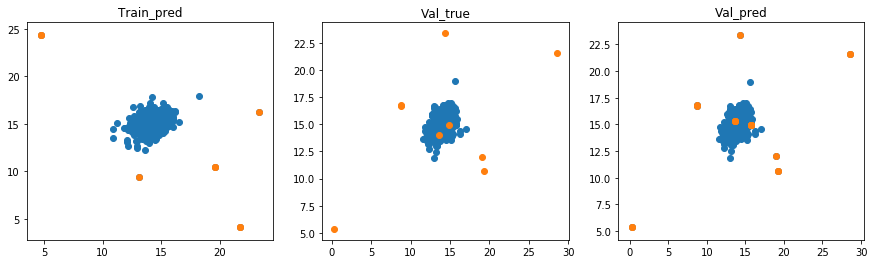

In [235]:
# 结果展示
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.title('Train_pred')
plt.scatter(X[:,0],X[:,1])
plt.scatter(X[train_outliers[0],0],X[train_outliers[0],1])
plt.subplot(1,3,2)
plt.title('Val_true')
plt.scatter(X_val[y_val==0][:,0],X_val[y_val==0][:,1])
plt.scatter(X_val[y_val==1][:,0],X_val[y_val==1][:,1])
plt.subplot(1,3,3)
plt.title('Val_pred')
plt.scatter(X_val[:,0],X_val[:,1])
plt.scatter(X_val[val_outliers,0],X_val[val_outliers,1])

### 多元

In [246]:
from sklearn.metrics import f1_score, classification_report

In [266]:
def select_threshold2(X, Xval, yval):
    # 训练集创建模型
    mu = X.mean(axis=0)
    cov = np.cov(X.T)
    multi_normal = stats.multivariate_normal(mu, cov)
    # 验证集调参
    pval = multi_normal.pdf(Xval)
    epsilon = np.linspace(np.min(pval), np.max(pval), num=10000)
    # 计算f1 score
    fs = []
    for e in epsilon:
        y_pred = (pval <= e).astype('int')
        fs.append(f1_score(yval, y_pred))
    # f1 score最大值
    argmax_fs = np.argmax(fs)
    return epsilon[argmax_fs], fs[argmax_fs]

In [267]:
def predict(X, Xval, e, Xtest, ytest):
    """用训练集和验证集构建高斯模型，在测试集上预测，使用阈值e划分异常样本并打印效果
    Returns:
        multi_normal: 多元高斯模型
        y_pred: 预测结果
    """
    Xdata = np.concatenate((X, Xval), axis=0)
    mu = Xdata.mean(axis=0)
    cov = np.cov(Xdata.T)
    multi_normal = stats.multivariate_normal(mu, cov)
    # 计算测试集概率密度
    pval = multi_normal.pdf(Xtest)
    y_pred = (pval <= e).astype('int')
    print(classification_report(ytest, y_pred))
    return multi_normal, y_pred

In [243]:
data2=sio.loadmat('./ex8data2.mat')

In [244]:
X = data2.get('X')
X_val = data2.get('Xval')
y_val = data2.get('yval').ravel()

In [259]:
Xval, Xtest, yval, ytest = train_test_split(X_val,y_val,test_size=0.4)

In [260]:
e, f = select_threshold2(X, Xval, yval.reshape((-1,1)))

In [261]:
multi_normal, y_pred = predict(X, Xval, e, Xtest, ytest)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        35
           1       0.80      0.80      0.80         5

    accuracy                           0.95        40
   macro avg       0.89      0.89      0.89        40
weighted avg       0.95      0.95      0.95        40

